In [1]:
import cv2
from shapely.geometry import Polygon

from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision import models
from torch import nn

import pandas as pd
from PIL import ImageEnhance

import torch
from torchvision import models
from torch.nn import CrossEntropyLoss
from torch.nn.functional import softmax
from torch.optim import Adam,lr_scheduler
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset
from utils_d import *

import sys

sys.path.append(r'E:\codes\python\area51m\pytorch_deeplab_xception')

from pytorch_deeplab_xception.modeling import deeplab

os.environ['TORCH_HOME'] = r'E:\data\MODELS' #setting the environment variable

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')

red = (255,0,0)
green = (0,255,0)
blue = (0,0,255)
yellow = (255,225,0)
orange = (255,125,0)
purple = (155,0,255)
greenblue = (0,255,225)
pink = (255,140,248)
colors = [red,green,blue,yellow,orange,purple,greenblue,pink]
labelnames = [' ','Window','Sky','Plant','Masonry','Hole','Gate','Signboard']

In [2]:
def predict_(image,transform_deeplab,transform_deeplab_detail,dlab2,dlab2_detail,label,original_size,thres=0.001,scale = 0.05):

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    dlab1 = models.segmentation.deeplabv3_resnet101(pretrained=1).eval().to(device)
    
    for p in dlab1.parameters():
        p.requires_grad = False

    _ = dlab1.eval()
    validation = transform_deeplab(image).unsqueeze(0).to(device)
    res= dlab1.backbone(validation)['out']
    res_ = dlab2.classifier(res)

    coordinates,prob = get_region_v2(res_.squeeze(),3,image.size,thres = 0.0001,scale = 0.05)
    coor_list = []
    mask_list = []
    om_list = []
    prob_list = []
    filtered_co = []
    for i,co in enumerate(coordinates):

        num = i

        x1 = co[0]
        x2 = co[2]
        y1 = co[1]
        y2 = co[3]

        if 0 not in np.array(image)[int(y1):int(y2),int(x1):int(x2)].shape:

            coor_list.append([(int(x1),int(y1)),(int(x2),int(y2))])
            filtered_co.append(co)
            prob_list.append(prob[i])

            frcnn_cropped = Image.fromarray(np.array(image)[int(y1):int(y2),int(x1):int(x2)])

            original_size = frcnn_cropped.size

            val = transform_deeplab(frcnn_cropped).unsqueeze(0).to(device)

            res_test_1 = dlab1.backbone(val)['out']

            res_test_2 = dlab2_detail.classifier(res_test_1)

            res_test = F.interpolate(res_test_2, size=(original_size[1],
                                                      original_size[0]), mode='bilinear', align_corners=False)

            torch.cuda.empty_cache()

            om = torch.argmax(res_test.squeeze(), dim=0).detach().cpu().numpy()
            om_list.append(om)
    
    binary_image = np.zeros(np.array(image).shape[:2])
    for mask,i in enumerate(coor_list):


        binary_image[coor_list[mask][0][1]:coor_list[mask][1][1],
        coor_list[mask][0][0]:coor_list[mask][1][0]] = om_list[mask]
        
    return binary_image

## loading the first model (deeplab v3 with resolution of 250x400)

In [3]:
image_size1 = (250,400)

transform1 = transforms.Compose([transforms.Resize(image_size1),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])


model1_1 = models.segmentation.deeplabv3_resnet101(pretrained=1).to(device)

for p in model1_1.parameters():
    p.requires_grad = False

_ = model1_1.eval()

model1_2 = models.segmentation.deeplabv3_resnet101(pretrained=0,num_classes=8).to(device)

model1_2.classifier.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model1_2.pth'))

_ = model1_2.eval()

for p in model1_2.parameters():
    p.requires_grad = False

model1_3 = models.segmentation.deeplabv3_resnet101(pretrained=0,num_classes=2).to(device)

model1_3.classifier.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model1_3.pth'))

for p in model1_2.parameters():
    p.requires_grad = False

_ = model1_3.eval()

class Model1(torch.nn.Module):
    def __init__(self,model1_1,model1_2):
        super().__init__()
        self.model1_1 = model1_1
        self.model1_2 = model1_2
    def forward(self,x,interpolate = True):
        x = self.model1_1.backbone(x)['out']
        x = self.model1_2.classifier(x)
        if interpolate:
            x = F.interpolate(x, size=(img1.size[1],img1.size[0]), mode='bilinear', align_corners=False)
            return x
        else:
            return x
        
model1_1_ = Model1(model1_1,model1_2)

## load the second model (deeplab v3+ with resolution of 250x400)

In [4]:
image_size2 = (250,400)
num_c = 2

transform2 = transforms.Compose([transforms.Resize(image_size2),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

model2_1 = deeplab.DeepLab(num_classes=8,backbone = 'resnet').to(device)

model2_1.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model2_1.pt'))

_ = model2_1.eval()

for p in model2_1.parameters():
    p.requires_grad = False

model2_2 = deeplab.DeepLab(num_classes=num_c,backbone = 'resnet').to(device)

model2_2.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model2_2.pt'))

for p in model2_2.parameters():
    p.requires_grad = False

_ = model2_2.eval()

## load the third model (deeplab v3+ with resolution of 900x900 and 400x400)

In [5]:
image_size3_1 = (900,900)
image_size3_2 = (400,400)
number_of_class_firstmodel = 8
number_of_class_secondmodel = 2

transform3_1 = transforms.Compose([transforms.Resize(image_size3_1),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

transform3_2 = transforms.Compose([transforms.Resize(image_size3_2),
                                transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

model3_1 = deeplab.DeepLab(num_classes=number_of_class_firstmodel,backbone = 'resnet').to(device)

model3_1.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model3_1.pt'))

_ = model3_1.eval()

for p in model3_1.parameters():
    p.requires_grad = False

model3_2 = deeplab.DeepLab(num_classes=number_of_class_secondmodel,backbone = 'resnet').to(device)

model3_2.load_state_dict(torch.load(r'E:\UCL\Dissertation\label\trained_models\model_comp\model3_2.pt'))

for p in model3_2.parameters():
    p.requires_grad = False

_ = model3_2.eval()

## load the image used for testing

In [6]:
dpi = 180

fontsize = 7

line_width = 12

In [7]:
imgname1 = r'20200104_130511.jpg'

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


(-0.5, 1959.5, 4031.5, -0.5)

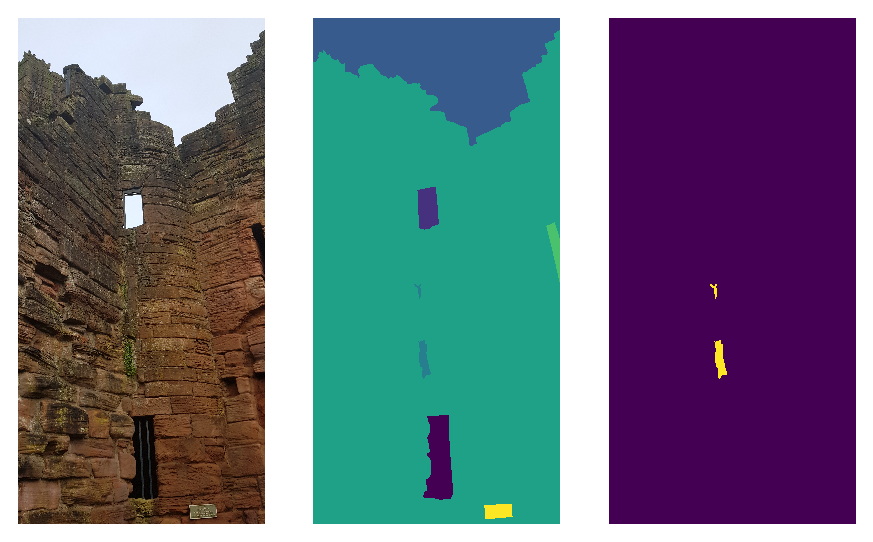

In [8]:
img1 = Image.open(r'E:\UCL\Dissertation\label\input_test\{0}'.format(imgname1)).rotate(-90,expand = True)
label1 = Image.open(r'E:\UCL\Dissertation\label\download_test\{0}'.format(imgname1.split('.')[0]+'_plants.png')).rotate(-90,expand = True)
get_label = GET_LABEL(size = img1.size)
data = pd.read_csv(r'E:\UCL\Dissertation\label\lb_test.csv')
overalllabel = transforms.ToTensor()(Image.fromarray(get_label(data[data['x_name'] == imgname1].index[0],
                                                               data,r'E:\UCL\Dissertation\label','\download_test').detach().numpy()).rotate(-90,expand = True).resize((img1.size))).round().to(int)
plt.figure(dpi = dpi)
plt.subplot(1,3,1)
plt.imshow(np.array(img1));plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(overalllabel.squeeze().numpy());plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(np.array(label1).sum(axis = 2));plt.axis('off')
plt.axis('off')

## test the first model

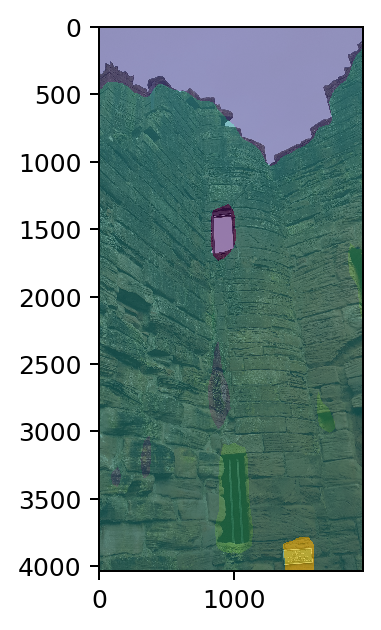

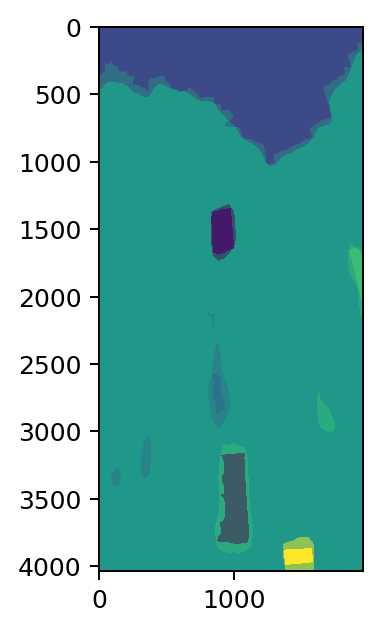

In [9]:
validation = transform2(img1).unsqueeze(0).to(device)
res= model1_1_(validation,interpolate = True)
res_test_1 = F.interpolate(res, size=(img1.size[1],
                                          img1.size[0]), mode='bilinear', align_corners=False)

plt.figure(dpi = dpi)
plt.imshow(np.array(img1))
plt.imshow(torch.argmax(res_test_1.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

plt.figure(dpi = dpi)
plt.imshow(overalllabel.squeeze().numpy())
plt.imshow(torch.argmax(res_test_1.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

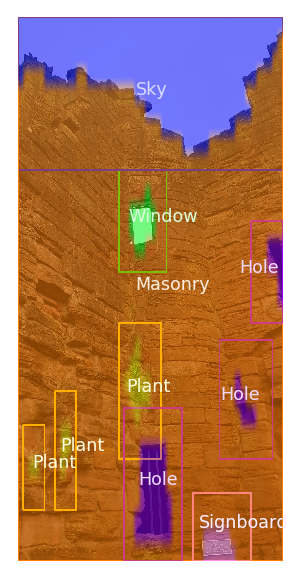

In [10]:
draw_bounding_box(img1,model1_1_,transform1,colors,labelnames,dpi,fontsize,line_width)

In [11]:
IoU(overalllabel.squeeze(),torch.argmax(res_test_1.squeeze(),axis = 0),8)

0 0.0
1 0.7585841826657186
2 0.9066058742963481
3 0.18971711068387806
4 0.9488204620601892
5 0.09724221454698186
7 0.45260425883324484


0.479082014726623

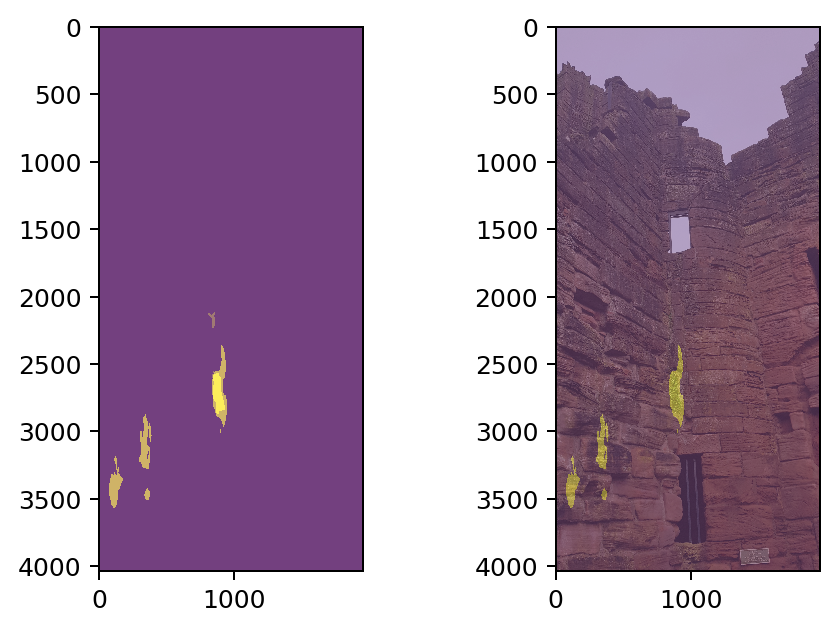

In [12]:
predicted_image1 = predict_(img1,transform1,transform1,model1_2,model1_3,3,img1.size,scale = 0.05)
plt.figure(dpi = dpi)
plt.subplot(1,2,1)
plt.imshow(np.array(label1).sum(axis = 2),alpha = 0.5)
plt.imshow(predicted_image1,alpha = 0.5)
plt.subplot(1,2,2)
plt.imshow(img1,alpha = 0.75)
plt.imshow(predicted_image1,alpha = 0.35)

## test the second model

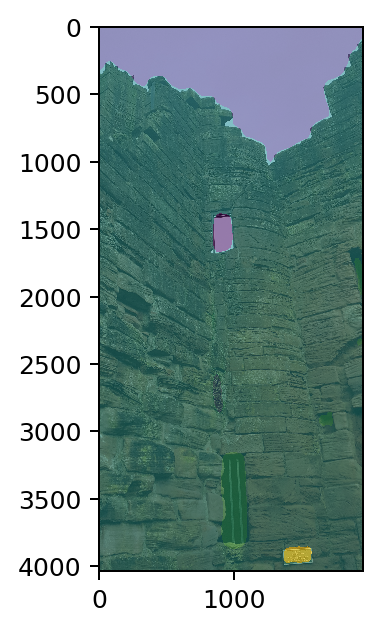

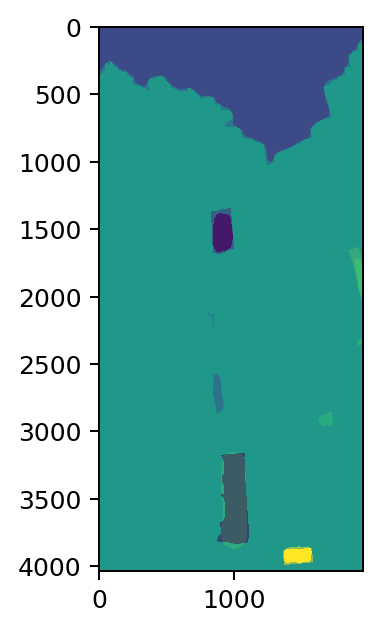

In [13]:
validation = transform2(img1).unsqueeze(0).to(device)
res= model2_1(validation,interpolate = True)
res_test_2 = F.interpolate(res, size=(img1.size[1],
                                          img1.size[0]), mode='bilinear', align_corners=False)

plt.figure(dpi = dpi)
plt.imshow(np.array(img1))
plt.imshow(torch.argmax(res_test_2.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

plt.figure(dpi = dpi)
plt.imshow(overalllabel.squeeze().numpy())
plt.imshow(torch.argmax(res_test_2.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

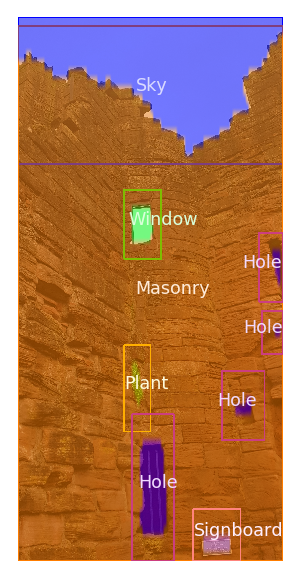

In [14]:
draw_bounding_box(img1,model2_1,transform2,colors,labelnames,dpi,fontsize,line_width)

In [15]:
IoU(overalllabel.squeeze(),torch.argmax(res_test_2.squeeze(),axis = 0),8)

0 0.0
1 0.7482659378429302
2 0.969856622932096
3 0.6900698215671063
4 0.9846471075201865
5 0.06530935844987791
7 0.7479001178214435


0.6008641380190914

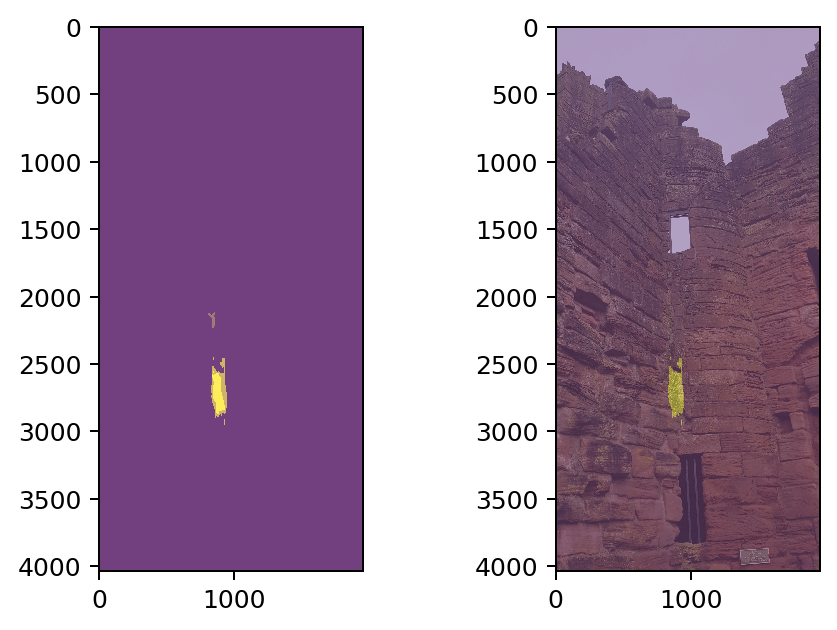

In [16]:
predicted_image2 = predict(img1,transform2,transform2,model2_1,model2_2,3,img1.size,scale = 0.05)
plt.figure(dpi = dpi)
plt.subplot(1,2,1)
plt.imshow(np.array(label1).sum(axis = 2),alpha = 0.5)
plt.imshow(predicted_image2,alpha = 0.5)
plt.subplot(1,2,2)
plt.imshow(img1,alpha = 0.75)
plt.imshow(predicted_image2,alpha = 0.35)

## test the third model

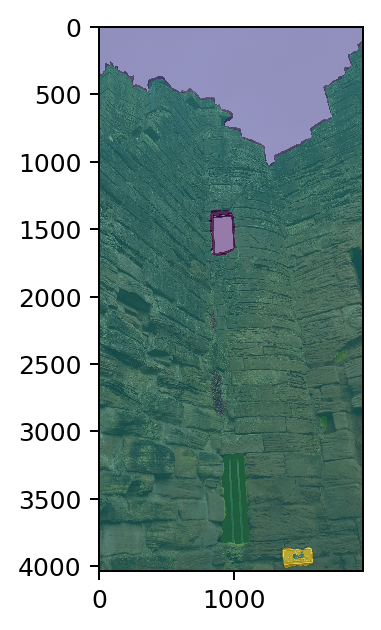

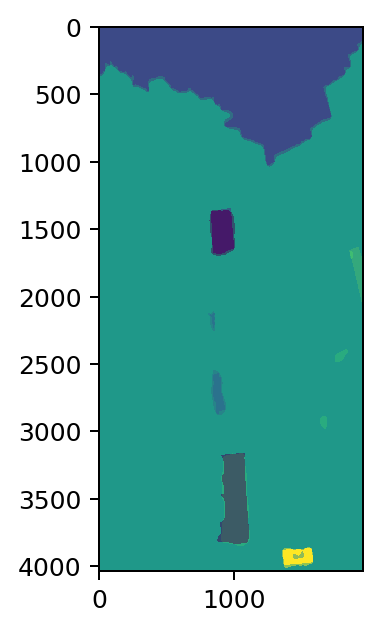

In [17]:
validation = transform3_1(img1).unsqueeze(0).to(device)
res= model3_1(validation,interpolate = True)
res_test_3 = F.interpolate(res, size=(img1.size[1],
                                          img1.size[0]), mode='bilinear', align_corners=False)

plt.figure(dpi = dpi)
plt.imshow(np.array(img1))
plt.imshow(torch.argmax(res_test_3.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

plt.figure(dpi = dpi)
plt.imshow(overalllabel.squeeze().numpy())
plt.imshow(torch.argmax(res_test_3.squeeze(),axis = 0).detach().cpu().numpy(),alpha = 0.5)

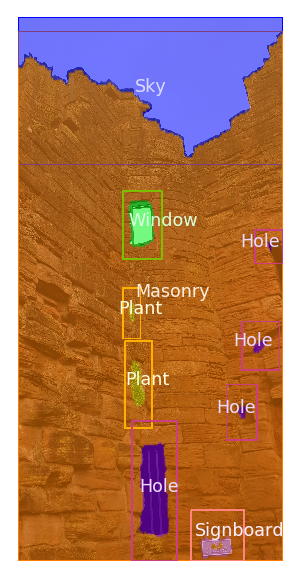

In [18]:
draw_bounding_box(img1,model3_1,transform3_1,colors,labelnames,dpi,fontsize,line_width)

In [19]:
IoU(overalllabel.squeeze(),torch.argmax(res_test_3.squeeze(),axis = 0),8)

0 0.0
1 0.824626344461517
2 0.9634194910019533
3 0.6356846746068303
4 0.9821211890680233
5 0.00604942264158122
7 0.7191015148876894


0.5901432338096564

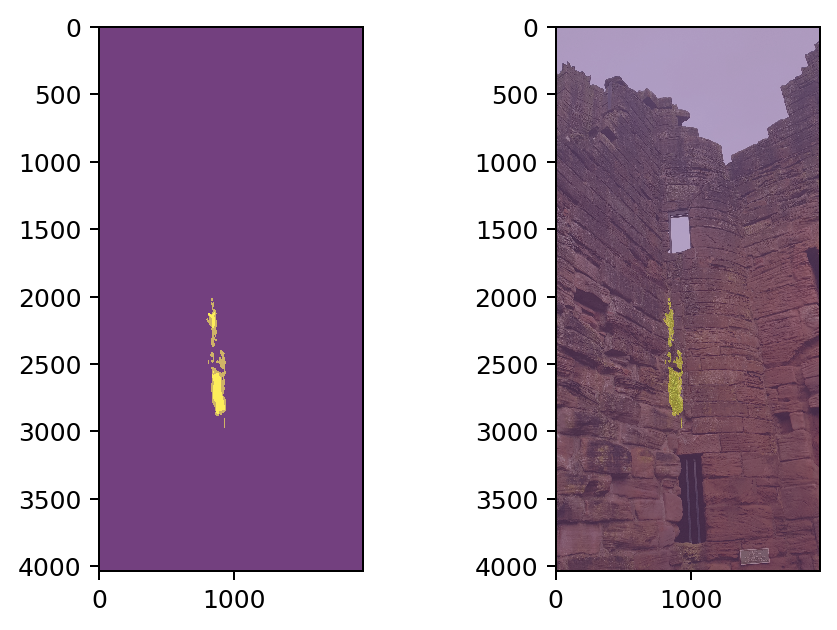

In [20]:
predicted_image3 = predict(img1,transform3_1,transform3_2,model3_1,model3_2,3,img1.size,scale = 0.05)
plt.figure(dpi = dpi)
plt.subplot(1,2,1)
plt.imshow(np.array(label1).sum(axis = 2),alpha = 0.5)
plt.imshow(predicted_image3,alpha = 0.5)
plt.subplot(1,2,2)
plt.imshow(img1,alpha = 0.75)
plt.imshow(predicted_image3,alpha = 0.35)